In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import random
import timm
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

!pip install torch efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from transformers import BertModel, BertTokenizer
from transformers import XLNetModel, XLNetTokenizer
from transformers import BertForSequenceClassification, XLNetForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a9b4f95f65aef29bb9c076aa6b9c82a0c91ebb39c6a338cdff36675bb02fe873
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(50)

In [4]:
images_path = "/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/Images"
train_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/train.xlsx'
test_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/test.xlsx'

In [5]:
train_df = pd.read_excel(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [6]:
train_df

,filename,tweet,label,image
0,buildingfire_2017-02-05_04-06-10.txt,Here's some video of the smoldering ruins in W...,damaged_infrastructure,buildingfire_2017-02-05_04-06-10.JPG
1,isiscrimes_2015-08-04_00-18-33.txt,27 person were killed yesterday near idlib nor...,human_damage,isiscrimes_2015-08-04_00-18-33.JPG
2,earthquake_2017-11-13_07-23-10.txt,تصویری از خسارات زلزله در سرپل ذهاب\n#earthqua...,damaged_infrastructure,earthquake_2017-11-13_07-23-10.JPG
3,ad_2017-11-25_07-56-53.txt,Link in bio #fashion #style #dt #friends #Inst...,non_damage,ad_2017-11-25_07-56-53.JPG
4,hurricanesandy_2017-10-29_22-36-42.txt,Covering the aftermath of Hurricane #Sandy 5 y...,flood,hurricanesandy_2017-10-29_22-36-42.JPG
...,...,...,...,...
5242,cars_2017-10-30_17-48-22.txt,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,non_damage,cars_2017-10-30_17-48-22.JPG
5243,buildingfire_2016-12-07_17-48-56.txt,Building fire yesterday in Boulder City #fire ...,fires,buildingfire_2016-12-07_17-48-56.JPG
5244,nature_2017-10-30_17-47-15.txt,Walking in the forest is soooooo relaxing ! \n...,non_damage,nature_2017-10-30_17-47-15.JPG
5245,ad_2017-11-25_11-07-37.txt,"a blue dream,💙 Use the code ""VANESSA35"" to get...",non_damage,ad_2017-11-25_11-07-37.JPG


In [7]:
rows_with_empty_values = train_df[train_df.isna().any(axis=1)]
print(rows_with_empty_values)

                        filename tweet       label                       image
2445  ad_2017-11-25_09-14-52.txt   NaN  non_damage  ad_2017-11-25_09-14-52.JPG


In [8]:
test_df

,filename,tweet,label,image
0,ad_2017-11-25_10-36-26.txt,⭐ We are really getting into the christmas spi...,non_damage,ad_2017-11-25_10-36-26.JPG
1,building_2017-10-30_17-26-34.txt,IJOY uv board has the competetive price and ve...,non_damage,building_2017-10-30_17-26-34.JPG
2,floodwater_2017-09-04_04-46-10.txt,Arriving in Kalkundi island destroyed in #bang...,flood,floodwater_2017-09-04_04-46-10.JPG
3,accrafloods_2015-06-06_16-59-56.txt,"Hi my lovelies, check out My first hand exper...",flood,accrafloods_2015-06-06_16-59-56.JPG
4,buildingfire_2016-10-02_03-07-17.txt,The Hamilton fire service during an exercise a...,fires,buildingfire_2016-10-02_03-07-17.JPG
...,...,...,...,...
579,floodwater_2017-08-27_23-49-50.txt,#gameofthrones #naturaldisaster #naturalmote #...,flood,floodwater_2017-08-27_23-49-50.JPG
580,nature_2017-10-30_17-47-50.txt,İyi İnsanlara Çıksın Gittiğimiz Tüm Yollar 🙏🏻❤...,non_damage,nature_2017-10-30_17-47-50.JPG
581,earthquake_2017-11-13_23-23-28.txt,Pray for Iran_kermanshah🙏🙏🙏\n.\nکرمانشاهم شهر ...,damaged_infrastructure,earthquake_2017-11-13_23-23-28.JPG
582,ad_2017-11-25_08-21-38.txt,A little hand painting using @framarint brushe...,non_damage,ad_2017-11-25_08-21-38.JPG


In [9]:
rows_with_empty_values = test_df[test_df.isna().any(axis=1)]
print(rows_with_empty_values)

Empty DataFrame
Columns: [filename, tweet, label, image]
Index: []


In [10]:
train_df['tweet'][0]

"Here's some video of the smoldering ruins in White Hall, IL. When I left I smelled like a campfire. 3 massive buildings destroyed by a giant fire. A local woman told me about it all. Just unbelievably sad. So much history and such a historic loss in a really small town. #smalltownusa #whitehall #centralillinois #illinois_shots #architecture #brickstagram #firedamage #buildingruins #exploreillinois #buildingfire"

In [11]:
print(len(train_df))
print(len(test_df))

5247
584


In [12]:
class_labels= ['ND','DI','DN','Fires','Flood','HD']

In [13]:
trdata = {
    'image': [],
    'tweet': [],
    'label': []
}
combinedf = pd.DataFrame(trdata)

tedata = {
    'image': [],
    'tweet': [],
    'label': []
}
testdf = pd.DataFrame(tedata)

label_map = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}

combinedf['label'] = train_df['label'].map(label_map)
testdf['label'] = test_df['label'].map(label_map)

def replace_string(row):
  return row.replace('.JPG', '.jpg')
combinedf['image'] = train_df['image'].apply(replace_string)
testdf['image'] = test_df['image'].apply(replace_string)

combinedf['tweet']= train_df['tweet']
testdf['tweet']= test_df['tweet']
# combinedf['tweet'].fillna('', inplace=True)
# testdf['tweet'].fillna('', inplace=True)

In [14]:
rows_with_empty_values = combinedf[combinedf.isna().any(axis=1)]
print(rows_with_empty_values)

                           image tweet  label
2445  ad_2017-11-25_09-14-52.jpg   NaN      0


In [15]:
rows_with_empty_values = testdf[testdf.isna().any(axis=1)]
print(rows_with_empty_values)

Empty DataFrame
Columns: [image, tweet, label]
Index: []


In [16]:
combinedf = combinedf.dropna().reset_index(drop=True)

In [17]:
rows_with_empty_values = combinedf[combinedf.isna().any(axis=1)]
print(rows_with_empty_values)

Empty DataFrame
Columns: [image, tweet, label]
Index: []


In [18]:
#combinedf = shuffle(combinedf, random_state=42)
traindf=combinedf[:4662]
validdf= combinedf[4662:]

In [19]:
print(len(combinedf))
print(len(traindf))
print(len(validdf))
print(len(testdf))

5246
4662
584
584


In [20]:
# traindf['image_exist'] = traindf['image'].apply(lambda x: os.path.exists(os.path.join(images_path, x)))

In [21]:
# traindf = traindf[traindf['image_exist']]
# traindf = traindf.drop(columns=['image_exist'])

In [22]:
traindf

,image,tweet,label
0,buildingfire_2017-02-05_04-06-10.jpg,Here's some video of the smoldering ruins in W...,1
1,isiscrimes_2015-08-04_00-18-33.jpg,27 person were killed yesterday near idlib nor...,5
2,earthquake_2017-11-13_07-23-10.jpg,تصویری از خسارات زلزله در سرپل ذهاب\n#earthqua...,1
3,ad_2017-11-25_07-56-53.jpg,Link in bio #fashion #style #dt #friends #Inst...,0
4,hurricanesandy_2017-10-29_22-36-42.jpg,Covering the aftermath of Hurricane #Sandy 5 y...,4
...,...,...,...
4657,ad_2017-11-25_09-56-23.jpg,Good Morning everyone! What‘s you plan for tod...,0
4658,hurricaneirma_2017-11-21_19-52-42.jpg,#rebuildthekeys #thisisourhome #orcspirit #oce...,2
4659,yemencrisis_2016-02-13_02-40-54.jpg,طفل من ألف طفل قتلتهم السعودية والإمارات..\nلن...,5
4660,building_2017-10-30_17-03-48.jpg,#many #group #city #building #architecture #la...,0


In [23]:
validdf

,image,tweet,label
4662,treesfalling_2013-12-22_18-58-11.jpg,Ice Storm 2013 ... My street\n❄❄❄❄❄❄❄❄❄\n#ices...,2
4663,ad_2017-11-25_04-12-10.jpg,1_Loveletter Ver.\n[ Follow to the Film ]\nEpi...,0
4664,ad_2017-11-25_10-45-52.jpg,"My text: “Send me coffee”\n•\n•\nSFMOMA bot, t...",0
4665,naturaldisaster_2017-10-13_07-10-42.jpg,Back home time for some cleaning.. @ surf popo...,2
4666,wreckedcar_2017-02-12_16-59-16.jpg,#wreck #car #wreckedcar #winter #snow #honor8,1
...,...,...,...
5241,cars_2017-10-30_17-48-22.jpg,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,0
5242,buildingfire_2016-12-07_17-48-56.jpg,Building fire yesterday in Boulder City #fire ...,3
5243,nature_2017-10-30_17-47-15.jpg,Walking in the forest is soooooo relaxing ! \n...,0
5244,ad_2017-11-25_11-07-37.jpg,"a blue dream,💙 Use the code ""VANESSA35"" to get...",0


In [24]:
validdf.reset_index(drop=True, inplace=True)

In [25]:
validdf

,image,tweet,label
0,treesfalling_2013-12-22_18-58-11.jpg,Ice Storm 2013 ... My street\n❄❄❄❄❄❄❄❄❄\n#ices...,2
1,ad_2017-11-25_04-12-10.jpg,1_Loveletter Ver.\n[ Follow to the Film ]\nEpi...,0
2,ad_2017-11-25_10-45-52.jpg,"My text: “Send me coffee”\n•\n•\nSFMOMA bot, t...",0
3,naturaldisaster_2017-10-13_07-10-42.jpg,Back home time for some cleaning.. @ surf popo...,2
4,wreckedcar_2017-02-12_16-59-16.jpg,#wreck #car #wreckedcar #winter #snow #honor8,1
...,...,...,...
579,cars_2017-10-30_17-48-22.jpg,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,0
580,buildingfire_2016-12-07_17-48-56.jpg,Building fire yesterday in Boulder City #fire ...,3
581,nature_2017-10-30_17-47-15.jpg,Walking in the forest is soooooo relaxing ! \n...,0
582,ad_2017-11-25_11-07-37.jpg,"a blue dream,💙 Use the code ""VANESSA35"" to get...",0


In [26]:
testdf

,image,tweet,label
0,ad_2017-11-25_10-36-26.jpg,⭐ We are really getting into the christmas spi...,0
1,building_2017-10-30_17-26-34.jpg,IJOY uv board has the competetive price and ve...,0
2,floodwater_2017-09-04_04-46-10.jpg,Arriving in Kalkundi island destroyed in #bang...,4
3,accrafloods_2015-06-06_16-59-56.jpg,"Hi my lovelies, check out My first hand exper...",4
4,buildingfire_2016-10-02_03-07-17.jpg,The Hamilton fire service during an exercise a...,3
...,...,...,...
579,floodwater_2017-08-27_23-49-50.jpg,#gameofthrones #naturaldisaster #naturalmote #...,4
580,nature_2017-10-30_17-47-50.jpg,İyi İnsanlara Çıksın Gittiğimiz Tüm Yollar 🙏🏻❤...,0
581,earthquake_2017-11-13_23-23-28.jpg,Pray for Iran_kermanshah🙏🙏🙏\n.\nکرمانشاهم شهر ...,1
582,ad_2017-11-25_08-21-38.jpg,A little hand painting using @framarint brushe...,0


In [27]:
class_counts = traindf['label'].value_counts()
print(class_counts)

0    2366
1    1114
2     405
4     300
3     274
5     203
Name: label, dtype: int64


In [28]:
class_counts = validdf['label'].value_counts()
print(class_counts)

0    299
1    132
2     54
4     48
3     35
5     16
Name: label, dtype: int64


In [29]:
class_counts = testdf['label'].value_counts()
print(class_counts)

0    291
1    144
2     55
3     37
4     36
5     21
Name: label, dtype: int64


In [30]:
transform_train = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [31]:
learning_rate = 3e-3
momentum = 0.9
beta_2 = 0.999
epsilon = None
weight_decay = 0.0
amsgrad = False

In [32]:
def callbacks_check(model_name):
    num_classes = 6
    accuracy_threshold = 0.99

    class MyCallback:
        def __init__(self):
            self.best_accuracy = 0.0

        def on_epoch_end(self, epoch, accuracy):
            if accuracy > accuracy_threshold:
                print("\nReached {:.2f}% accuracy, so we will stop training".format(accuracy_threshold * 100))
                return True
            return False

    acc_callback = MyCallback()
    
    return acc_callback

# **Combine**

In [33]:
class CustomCombinedDataset(Dataset):
    def __init__(self, dataframe, images_path, tokenizer, max_length, transforms=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[index]['label']

        tweet = str(self.dataframe.loc[index, 'tweet'])

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            padding='max_length'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.transforms is not None:
            image = self.transforms(image)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length= 300

In [35]:
combined_train_dataset = CustomCombinedDataset(traindf, images_path, tokenizer, max_length, transforms=transform_train)
combined_valid_dataset = CustomCombinedDataset(validdf, images_path, tokenizer, max_length, transforms=transform_test)
combined_test_dataset = CustomCombinedDataset(testdf, images_path, tokenizer, max_length, transforms=transform_test)

In [36]:
len(combined_train_dataset)

4662

In [37]:
criterion = nn.CrossEntropyLoss()
num_classes = 6
batch_size = 12
num_iters= 30000
num_epochs = num_iters / (len(combined_train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

77


In [38]:
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
combined_valid_loader = DataLoader(combined_valid_dataset, batch_size=batch_size, shuffle=False)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
len(combined_train_loader)

389

In [40]:
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        
#         # Image Model (ResNet-50)
#         self.image_model = models.resnet50(pretrained=True)   
#         num_image_features = self.image_model.fc.in_features
#         self.image_model.fc = nn.Sequential(
#             nn.Linear(num_image_features, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate)
#         )

#         self.image_model = models.densenet201(pretrained=True)
#         torch.nn.Sequential(*list(self.image_model.children())[:-1])
#         num_features = self.image_model.classifier.in_features
#         self.image_model.classifier = nn.Sequential(
#             nn.Linear(num_features, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate)
#         )
       
        self.image_model = EfficientNet.from_pretrained('efficientnet-b3')
        torch.nn.Sequential(*list(self.image_model.children())[:-1])
        num_features = self.image_model._fc.in_features
        self.image_model._fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        
        # Text Model (BERT)
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_linear = nn.Linear(self.text_model.config.hidden_size, 512)
        
        # Fusion Layer
        self.fusion_linear = nn.Linear(1024, num_classes)
    
    def forward(self, image_input, text_input_ids, text_attention_mask):
        # Process image
        image_features = self.image_model(image_input)
        
        # Process text
        text_outputs = self.text_model(text_input_ids, attention_mask=text_attention_mask)
        pooled_text_output = text_outputs.pooler_output
        text_features = self.text_linear(pooled_text_output)
        
        # Concatenate image and text features
        multimodal_features = torch.cat((image_features, text_features), dim=1)
        
        # Fusion layer
        combined_logits = self.fusion_linear(multimodal_features)
        
        return combined_logits

In [41]:
num_classes = 6
dropout_rate= 0.2

In [42]:
# img_model = ImageModel
# text_model = TextModel

combined_model = MultimodalClassifier()
combined_model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 74.5MB/s]


Loaded pretrained weights for efficientnet-b3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MultimodalClassifier(
  (image_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dSt

In [43]:
learning_rate = 1e-4
momentum = 0.9
beta_2 = 0.999
epsilon = None
weight_decay = 0.0
amsgrad = False

In [44]:
optimizer = optim.Adam(combined_model.parameters(),
                           lr=learning_rate)

criterion = nn.CrossEntropyLoss()

In [45]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [46]:
patience = 15
best_val_loss = float('inf')
counter = 0

callback_list = callbacks_check(combined_model)

for epoch in range(num_epochs):
    combined_model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    
    for batch_idx, batch_data in enumerate(combined_train_loader):
        
        images = batch_data['image'].to(device)
        input_ids = batch_data['input_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        labels = batch_data['label'].to(device)
        
        optimizer.zero_grad()
        
        img_output = combined_model(images, input_ids, attention_mask)
        
        loss = criterion(img_output, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(img_output, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = total_loss / len(combined_train_loader)
    epoch_accuracy = correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')
    
    combined_model.eval()
    valid_correct = 0
    valid_total_samples = 0
    valid_loss = 0.0
    
    with torch.no_grad():
        for valid_batch_data in combined_valid_loader:
            valid_images = valid_batch_data['image'].to(device)
            valid_input_ids = valid_batch_data['input_ids'].to(device)
            valid_attention_mask = valid_batch_data['attention_mask'].to(device)
            valid_labels = valid_batch_data['label'].to(device)
            
            valid_output = combined_model(valid_images, valid_input_ids, valid_attention_mask)
            valid_loss += criterion(valid_output, valid_labels).item()
            
            _, valid_predicted = torch.max(valid_output, 1)
            valid_correct += (valid_predicted == valid_labels).sum().item()
            valid_total_samples += valid_labels.size(0)
            
    valid_epoch_loss = valid_loss / len(combined_valid_loader)
    valid_epoch_accuracy = valid_correct / valid_total_samples
    valid_losses.append(valid_epoch_loss)
    valid_accuracies.append(valid_epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {valid_epoch_loss:.4f}, Validation Accuracy: {valid_epoch_accuracy:.4f}')
    
    if callback_list.on_epoch_end(epoch+1,epoch_accuracy):
            print(print("Early stopping triggered at epoch",epoch+1))
            break
            
    elif (valid_epoch_loss < best_val_loss):
            best_val_loss = valid_epoch_loss
            counter = 0
            torch.save(combined_model.state_dict(),'Combine_best_model.pt')
            print("Combine Model saved")
            combined_model.train()
            
    else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}.')
                break

Epoch [1/77], Train Loss: 0.4811, Train Accuracy: 0.8494
Epoch [1/77], Validation Loss: 0.3461, Validation Accuracy: 0.8921
Combine Model saved
Epoch [2/77], Train Loss: 0.2159, Train Accuracy: 0.9311
Epoch [2/77], Validation Loss: 0.3235, Validation Accuracy: 0.9041
Combine Model saved
Epoch [3/77], Train Loss: 0.1650, Train Accuracy: 0.9408
Epoch [3/77], Validation Loss: 0.3919, Validation Accuracy: 0.8818
Epoch [4/77], Train Loss: 0.1761, Train Accuracy: 0.9380
Epoch [4/77], Validation Loss: 0.2811, Validation Accuracy: 0.9247
Combine Model saved
Epoch [5/77], Train Loss: 0.0930, Train Accuracy: 0.9685
Epoch [5/77], Validation Loss: 0.2589, Validation Accuracy: 0.9332
Combine Model saved
Epoch [6/77], Train Loss: 0.0617, Train Accuracy: 0.9824
Epoch [6/77], Validation Loss: 0.3340, Validation Accuracy: 0.9127
Epoch [7/77], Train Loss: 0.0966, Train Accuracy: 0.9661
Epoch [7/77], Validation Loss: 0.3626, Validation Accuracy: 0.9075
Epoch [8/77], Train Loss: 0.0905, Train Accuracy: 0.

In [79]:
combined_model.load_state_dict(torch.load('Combine_best_model.pt'))
print('Model Loaded')

Model Loaded


In [85]:
ctest_labels_lst=[]
ctest_predicted_lst=[]

In [86]:
with torch.no_grad():
    for ctest_batch_data in combined_test_loader:
        ctest_images = ctest_batch_data['image'].to(device)
        ctest_input_ids = ctest_batch_data['input_ids'].to(device)
        ctest_attention_mask = ctest_batch_data['attention_mask'].to(device)
        ctest_labels = ctest_batch_data['label'].to(device)
        
        ctest_output = combined_model(ctest_images, ctest_input_ids, ctest_attention_mask)
        
        _, ctest_predicted = torch.max(ctest_output, 1)
        ctest_labels_lst.extend(ctest_labels.cpu().numpy()) 
        ctest_predicted_lst.extend(ctest_predicted.cpu().numpy())

In [88]:
ctest_labels_np = np.array(ctest_labels_lst)
ctest_predicted_np = np.array(ctest_predicted_lst)

sklearn_accuracy = accuracy_score(ctest_labels_np, ctest_predicted_np)
precision = precision_score(ctest_labels_np, ctest_predicted_np, average='weighted')
recall = recall_score(ctest_labels_np, ctest_predicted_np, average='weighted')
f1 = f1_score(ctest_labels_np, ctest_predicted_np, average='weighted')

print(f'Accuracy: {sklearn_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9366
Precision: 0.9385
Recall: 0.9366
F1 Score: 0.9368


In [95]:
class_labels= ['ND','DI','DN','Fires','Flood','HD']

In [90]:
true_labels = np.array(ctest_labels_lst)
predicted_labels = np.array(ctest_predicted_lst)


In [91]:
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

print("Classification Report:")
print(report)

Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.99      0.99      0.99       291
damaged_infrastructure       0.93      0.88      0.90       144
        damaged_nature       0.81      0.87      0.84        55
                 fires       0.86      0.84      0.85        37
                 flood       0.83      0.97      0.90        36
          human_damage       1.00      0.86      0.92        21

              accuracy                           0.94       584
             macro avg       0.90      0.90      0.90       584
          weighted avg       0.94      0.94      0.94       584



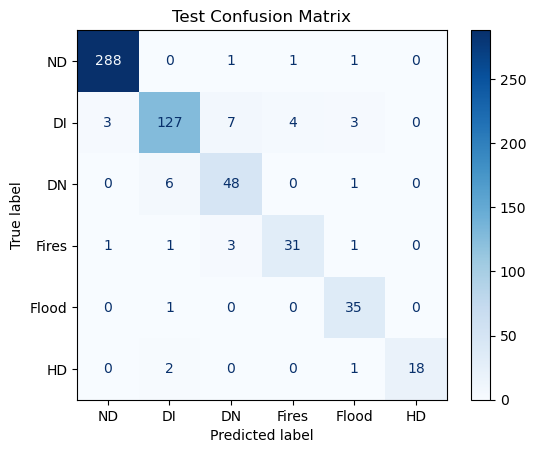

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_confusion = confusion_matrix(ctest_labels_lst, ctest_predicted_lst)
test_confusion_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion, display_labels=class_labels)
test_confusion_display.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')
plt.show()